<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

# Logistic regression

Week 5 | 2.1

---

Logistic regression is arguably the most famous and well used classifier. It _is_ a regression, but don't let that confuse you: it estimates probabilities of class membership.

It is widely used in cases where the probability of an outcome (classification) is required. In this lecture we will only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to multiple classes.

Some examples of when logistic regression could be used:

- Predict whether or not a user will purchase a product given their demographic characteristics.
- Predict the likelihood of a student being admitted to a college, given their scores and the characteristics of the college.
- Diagnose a patient with a disease or not, given symptoms.
- Predict whether a person will default on a loan and with what likelihood.

And many more. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm

In [5]:
colors = {'blue': '#729ECE',
          'brown': '#A8786E',
          'green': '#67BF5C',
          'grey': '#A2A2A2',
          'orange': '#FF9E4A',
          'pink': '#ED97CA',
          'purple': '#AD8BC9',
          'red': '#ED665D',
          'teal': '#6DCCDA',
          'yellow': '#CDCC5D'}

In [6]:
admissions = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-4/datasets/admissions/admissions.csv')

In [7]:
admissions.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


---

### 1. A (brief) review of regression models

To understand how logistic regression works, we need to understand least squares regression. 

As you are all familiar with, a regression with variable(s) matrix $X$ predicting target $y$ is formulated as:

### $$E[y|X] = \beta_0 + \sum_{j}^p\beta_jx_j$$

Where:
- $E(y|X)$ is the expected value (mean) of y given variable matrix $X$
- $\sum_{j}^p$ are the predictors $j$ thru $p$ (columns) of the $X$ matrix
- $beta_0$ is the intercept
- $beta_j$ is the coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$

---

### 2. What if we predicted `admit` with `gpa` using regression?

In [10]:
admit = admissions.dropna()

In [11]:
y = admit.admit.values
X = admit[['gpa']].values

linreg = LinearRegression()
linreg.fit(X, y)

print linreg.coef_
print linreg.intercept_

[ 0.21342491]
-0.406608559967


//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [12]:
print np.min(admit.gpa), np.max(admit.gpa)

2.26 4.0


---

### 3. What do those coefficients mean?  Plot admit ~ gpa

What is the apparent problem with regression?

In [17]:
a = np.array([1,2,3,4,5])
a[:, np.newaxis]

array([[1],
       [2],
       [3],
       [4],
       [5]])

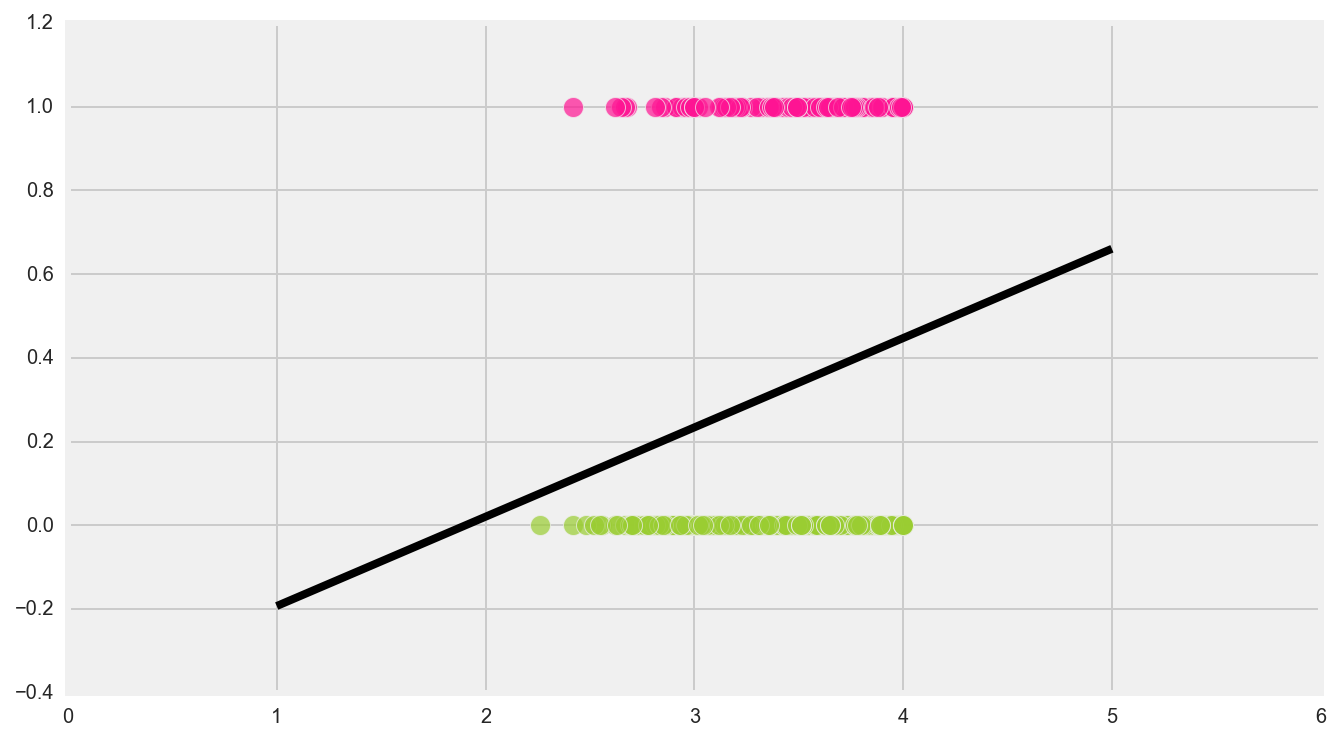

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

admitted_mask = admit.admit == 1
not_admitted = ~admitted_mask

ax.scatter(admit[admitted_mask].gpa, 
           admit[admitted_mask].admit,
           c='deeppink', s=100, alpha=0.7)

ax.scatter(admit[not_admitted].gpa, 
           admit[not_admitted].admit,
           c='yellowgreen', s=100, alpha=0.7)

x_vals = np.linspace(1.0, 5.0, 200)
y_vals = linreg.predict(x_vals[:, np.newaxis])

ax.plot(x_vals, y_vals, lw=4, color='black')

plt.show()

---

### 5. Binary classes case

Logistic regression can solve multi-class problems – we will look at this another day – but the basic classification problem is binary. 

In our case, `1=admitted` and `0=rejected`.

The logistic regression is still solving for an expected value. In the binary classification case this expected value is the probability of one class:

### $$E[y \in {0,1}] = P(y = 1)$$

In regression syntax we would have:

### $$P(y = 1) = \beta_0 + \sum_{j}^p\beta_jx_j$$

---

### 6. The dilemma: probability estimation using regression

### $$P(y = 1) = \beta_0 + \sum_{j}^p\beta_jx_j$$

There is an important problem with this new equation: we want to estimate a probability instead of a real number.

Why is this a problem?


#### We need $y$ to fall in the range `[-infinity, infinity]` for the regression to be valid!

---

### 4. The logit "link function"

As the name implies, logistic regression is still a regression. It can still be solved by minimization of the sum of squared errors, and there is still an intercept and coefficients.

Logistic regression is a twist on regression for categorical/class target variables. Instead of solving for the _mean_ of $y$, logistic regression solves for the _probability of class membership_ of $y$.

How does it do this? Regressions can be generalized to $y$ targets that do not fall between `[-infinity, infinity]` through the use of **link functions**.

A link function is simply a function of the expected value of the target variable:

### $$logit(\;E[\;y \;| \;X\;]\;) = \beta_0 + \sum_{j}^p\beta_jx_j$$

1. Probabilities are guaranteed to be between 0 and 1.
2. The regression formula makes no guarantee that the sum of predictors multiplied by coefficients will sum to a value between 0 and 1.

---

### 7. Step 1: Odds ratios

We have to modify the regression for it to work for predicting probabilities. The initial step in the solution depends on the use of **odds ratios**. Before we get into _why_, it's important to understand what an odds ratio is.

Probabilities and odds ratios represent the same thing in different ways. Probabilities can be alternatively expressed as odds ratios. The odds ratio for probability **p** is defined:

### $$\text{odds ratio}(p) = \frac{p}{1-p}$$

The odds ratio of a probability is a measure of how many times more likely it is than the inverse case.

For example:

- When **`p = 0.5`**: **`odds ratio = 1`**
    - it is equally likely to happen as it is to not happen.
- When **`p = 0.75`**: **`odds ratio = 3`**
    - it is 3 times more likely to happen than not happen.
- When **`p = 0.40`**: **`odds ratio = 0.666..`**
    - it is 2/3rds as likely to happen than not happen.

#### What are the probabilities of admittance by prestige?

In [20]:
def p_to_odds(p):
    return p / (1. - p)

p_to_odds(0.05)

0.052631578947368425

#### Write a function to calculate odds ratios and calculate the odds ratios of admittance by prestige.

In [21]:
y_p1 = admit[admit.prestige == 1].admit
y_p4 = admit[admit.prestige == 4].admit

In [25]:
print 'P(admit = 1 | prestige = 1)', np.mean(y_p1)
print 'P(admit = 1 | prestige = 4)', np.mean(y_p4)

P(admit = 1 | prestige = 1) 0.540983606557
P(admit = 1 | prestige = 4) 0.179104477612


In [26]:
admit.prestige.value_counts()

2.0    148
3.0    121
4.0     67
1.0     61
Name: prestige, dtype: int64

In [24]:
admit.groupby('prestige').agg(np.mean)

,admit,gre,gpa
prestige,,,
1.0,0.540984,611.803279,3.453115
2.0,0.358108,596.621622,3.367365
3.0,0.231405,574.876033,3.432893
4.0,0.179104,570.149254,3.318358


---

### 8: Odds ratio in place of probability

What happens if we put the odds ratio in place of the probability in the regression equation?

Put the odds ratio in place of the probability on the left side of the regression equation.

### $$ \frac{P(y = 1)}{1-P(y = 1)} = \beta_0 + \sum_{j}^p\beta_jx_j$$

The range of odds ratio, our predicted value, is now restricted to be in the range **`[0, infinity]`**


#### What happens if we just the odds ratio as the link function?

---

### 9. Step 2: Log odds (natural logarithm of the odds ratio)

If we take the natural logarithm of a variable that falls between 0 and infinity, we can actually transform it into a variable that falls between the range negative infinity and infinity.

This is because taking the logarithm of fractions results in negative numbers.

The regression can now predict any negative or positive number, and we can convert it back into the odds ratio.

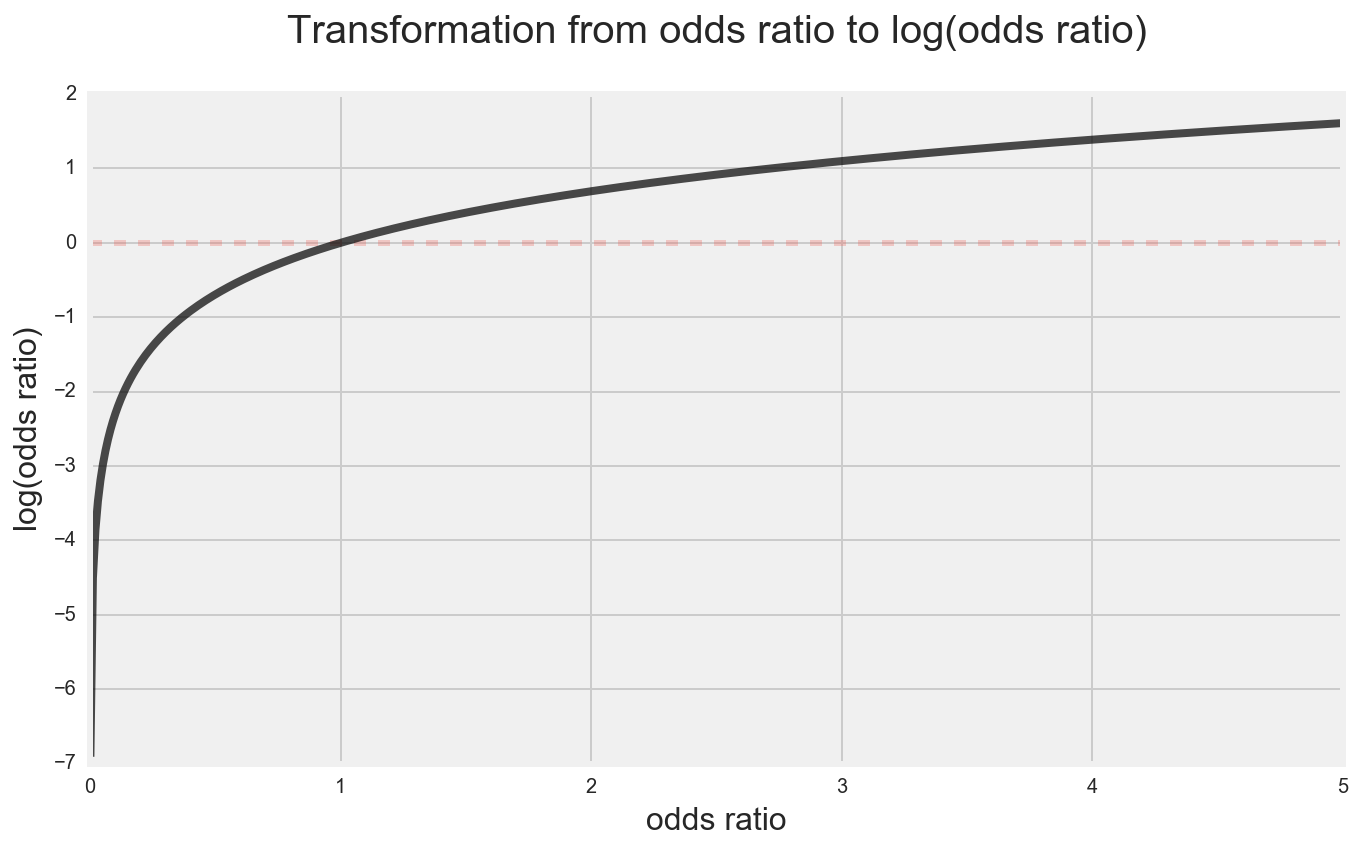

In [27]:
xs = np.linspace(0.001, 5, 500)
ys = np.log(xs)

plt.figure(figsize=[10,6])
plt.axhline(y=0, linewidth=3, c=colors['red'], ls='dashed', alpha=0.3)
plt.plot(xs, ys, lw=4, c='black', alpha=0.7)

plt.xlabel('odds ratio', fontsize=16)
plt.ylabel('log(odds ratio)', fontsize=16)
plt.title('Transformation from odds ratio to log(odds ratio)\n',fontsize=20)

---

## 10. The logit link function

The combination of converting the probability to an odds ratio and taking the logarithm of that is called the **logit link function**, and is what regression uses to estimate probability:


### $$\text{logit}\big(E[y]\big) = \text{logit}\big(P(y=1)\big) = log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) =  \beta_0 + \sum_{j}^p\beta_jx_j$$



---

### 11. How do we get probabilities out? Inverting the logit link function with the "logistic"

The inverse function of the logit is called the **logistic function**. 

By inverting the logit, we can have the right side of our regression equation explicitly solving for $P(y = 1)$:

### $$P(y=1) = logit^{-1}\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)$$

Where:

### $$logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}$$ 

Giving us:

### $$P(y=1) = \frac{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}}{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}+1}$$

---

### 11.B Solving for the beta coefficients

Logistic regression minimizes the "deviance", which is analagous to the residual sum of squares in linear regression. There is not a closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.

If you are particularly interested in the math, these two resources are good:

[A good blog post on the logistic regression beta coefficient derivation.](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/)

[This paper is also a good reference.](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf)



---

### 12. Interpreting logistic regression coefficients.

The interpretation of logistic regression coefficients can be counter-intuitive. 

**To make it easier, start by centering your predictor variables (subtracting the mean):**

#### Why does centering matter?

Centering helps a lot because now the "baseline" for the predictor, the value at 0, is the mean of the predictor. So, in our case, when gpa = 0 this is the average gpa across students.

After re-running the regression we can take a look at the coefficients:

#### Meaning of the betas in log odds

Remember that our values are in terms of log-odds. 

> If $\beta_1$ is 0, then $\beta_0$ represents the log odds of admittance for a student with an average gpa.

> $\beta_1$ is the effect of a unit increase in gpa on the log odds of admittance. 

This sucks because log odds are hard to interpret. Luckily though, we can apply the logistic transform to get the probability of admittance at different $\beta$ values.

The probability of admittance with an average gpa:

** With more coefficients, setting $\beta$ values other than the one of interest to zero (except the intercept) will let you see the change in probability as the corresponding $x$ variable changes.**